## Setup

In [1]:
import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [42]:
baseball = pd.read_csv('data/baseball.csv')
baseball = baseball.drop(['Name', 'Age', 'Name-additional'], axis = 1)
baseball['Salary'] = baseball['Salary'].str.replace('$', '').astype(float)

baseball['Pos_C'] = baseball['Position'].apply(lambda x: 1 if 'C' in x else 0)
baseball['Pos_1B'] = baseball['Position'].apply(lambda x: 1 if '1B' in x else 0)
baseball['Pos_2B'] = baseball['Position'].apply(lambda x: 1 if '2B' in x else 0)
baseball['Pos_3B'] = baseball['Position'].apply(lambda x: 1 if '3B' in x else 0)
baseball['Pos_SS'] = baseball['Position'].apply(lambda x: 1 if 'SS' in x else 0)
baseball['Pos_OF'] = baseball['Position'].apply(lambda x: 1 if 'OF' in x else 0)

baseball['Num_Pos'] = baseball[['Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B', 'Pos_SS', 'Pos_OF']].sum(axis = 1)
baseball['R/AB'] = baseball['R'] / baseball['AB']
baseball['2B/AB'] = baseball['2B'] / baseball['AB']
baseball['3B/AB'] = baseball['3B'] / baseball['AB']
baseball['HR/AB'] = baseball['HR'] / baseball['AB']
baseball['RBI/AB'] = baseball['RBI'] / baseball['AB']
baseball['BB/PA'] = baseball['BB'] / baseball['PA']
baseball['SB - CS'] = baseball['SB'] - baseball['CS']
baseball['BB - SO'] = baseball['BB'] - baseball['SO'] # measures a batters eye
baseball['E/Def-Inn'] = baseball['E'] / baseball['Def-Inn']
baseball['DP/Def-Inn'] = baseball['DP'] / baseball['Def-Inn']

baseball = baseball.drop(['Position', 'Def-Inn', 'PO', 'A', 'E', 'DP', 'PA', 'AB', 'R', 'H', 
                          '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB'], axis = 1)

X = baseball.drop(['Salary', 'cluster'], axis = 1)
y = baseball['Salary']

In [43]:
cat_columns = ['Tm', 'Lg', 'Acquired', 'Bat']
num_columns = [col for col in X.columns if col not in cat_columns + ['C', '1B', '2B', '3B', 'SS', 'OF']]

cat_transformer = Pipeline(
    steps = [
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
    ]
)

num_transformer = Pipeline(
    steps = [
        ('scale', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ('cont', num_transformer, num_columns),
        ('cat', cat_transformer, cat_columns)
    ], remainder = 'passthrough'
)

selected_features = np.concatenate([
    np.array(num_columns),
    np.array(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(cat_columns)),
    np.array(['Pos_C', 'Pos_1B', 'Pos_2B', 'Pos_3B', 'Pos_SS', 'Pos_OF'])
])


AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

## EDA

In [5]:
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [6]:
# sns.pairplot(baseball)
kmeans = KMeans(n_clusters = 4, n_init = 'auto')
kmeans.fit(X)

baseball['cluster'] = kmeans.labels_

Text(0, 0.5, 'WCSS')

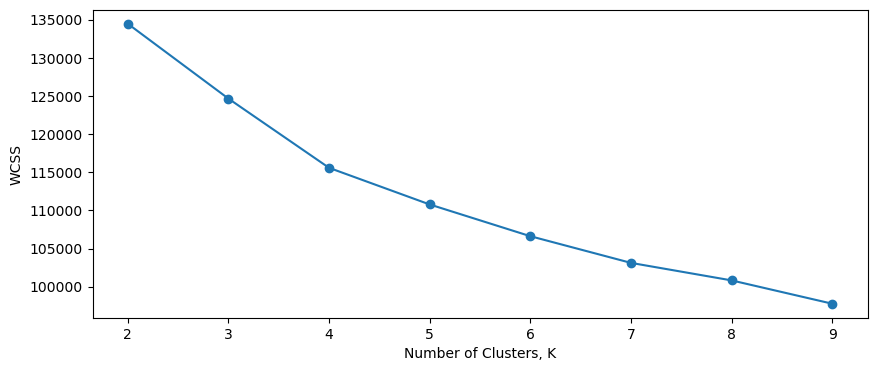

In [7]:
kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=621).fit(X_transform)
                for k in range(2, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(10,4))
plt.plot(range(2, 10),inertias,marker="o")
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS')

In [17]:
baseball.columns

Index(['Tm', 'Lg', 'Fld%', 'Rdrs', 'Season', 'RAA', 'WAA', 'RAR', 'WAR',
       'Salary', 'Acquired', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'Bat', 'Pos_C',
       'Pos_1B', 'Pos_2B', 'Pos_3B', 'Pos_SS', 'Pos_OF', 'Num_Pos', 'R/AB',
       '2B/AB', '3B/AB', 'HR/AB', 'RBI/AB', 'BB/PA', 'SB - CS', 'BB - SO',
       'E/Def-Inn', 'DP/Def-Inn', 'cluster'],
      dtype='object')

<Axes: xlabel='RBI/AB', ylabel='WAR'>

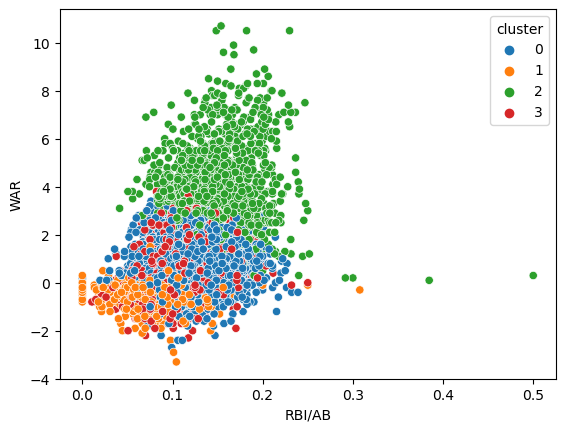

In [19]:
sns.scatterplot(baseball, x = 'RBI/AB', y = 'WAR', hue = 'cluster', palette = 'tab10')

<Axes: xlabel='Salary', ylabel='Bat'>

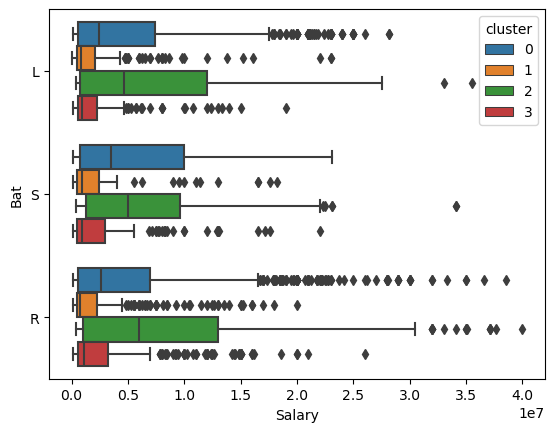

In [21]:
sns.boxplot(baseball, y = 'Bat', x = 'Salary', hue = 'cluster')

<Axes: xlabel='Salary', ylabel='Acquired'>

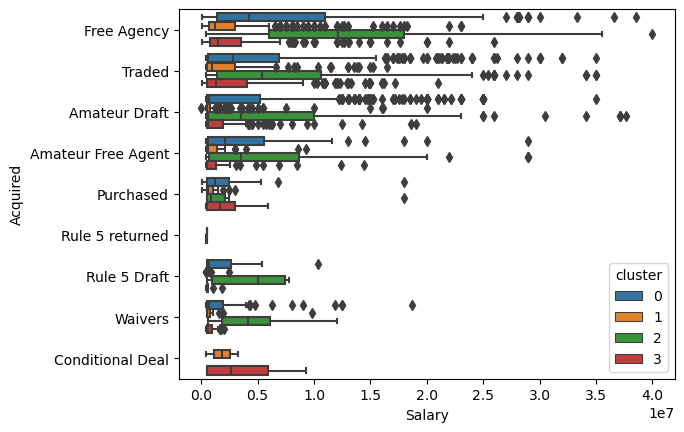

In [22]:
sns.boxplot(baseball, y = 'Acquired', x = 'Salary', hue = 'cluster')

In [25]:
# cluster 0
cluster_0 = baseball[baseball['cluster'] == 0]

# cluster 1
cluster_1 = baseball[baseball['cluster'] == 1]

# cluster 2
cluster_2 = baseball[baseball['cluster'] == 2]

# cluster 3
cluster_3 = baseball[baseball['cluster'] == 3]

print('CLUSTER 0')
print(cluster_0['Salary'].describe())
print('CLUSTER 1')
print(cluster_1['Salary'].describe())
print('CLUSTER 2')
print(cluster_2['Salary'].describe())
print('CLUSTER 3')
print(cluster_3['Salary'].describe())

CLUSTER 0
count    2.283000e+03
mean     5.289918e+06
std      6.376275e+06
min      1.000000e+05
25%      5.697500e+05
50%      2.637500e+06
75%      7.329166e+06
max      3.857143e+07
Name: Salary, dtype: float64
CLUSTER 1
count    6.680000e+02
mean     2.234966e+06
std      3.515318e+06
min      1.000000e+00
25%      5.124250e+05
50%      7.750000e+05
75%      2.256250e+06
max      2.300000e+07
Name: Salary, dtype: float64
CLUSTER 2
count    1.235000e+03
mean     7.756504e+06
std      7.784772e+06
min      4.000000e+05
25%      9.607000e+05
50%      5.325000e+06
75%      1.200000e+07
max      4.000000e+07
Name: Salary, dtype: float64
CLUSTER 3
count    8.750000e+02
mean     2.595606e+06
std      3.620202e+06
min      1.000000e+05
25%      5.192125e+05
50%      1.000000e+06
75%      3.000000e+06
max      2.600000e+07
Name: Salary, dtype: float64


In [41]:
test = baseball[baseball['Salary'] == 1.0]
print(test['Season'])
print(test['Salary'])

t = baseball.drop(170)
t.reset_index(inplace = True, drop = True)
t.loc[170]

170    2010
Name: Season, dtype: int64
170    1.0
Name: Salary, dtype: float64


Tm                    STL
Lg                     NL
Fld%                0.989
Rdrs                   14
Season               2010
RAA                    39
WAA                   3.9
RAR                    60
WAR                   5.9
Salary         16333327.0
Acquired      Free Agency
BA                  0.312
OBP                  0.39
SLG                 0.532
OPS                 0.922
OPS+                149.0
Bat                     R
Pos_C                   0
Pos_1B                  0
Pos_2B                  0
Pos_3B                  0
Pos_SS                  0
Pos_OF                  1
Num_Pos                 1
R/AB             0.159396
2B/AB            0.075503
3B/AB            0.001678
HR/AB             0.04698
RBI/AB           0.172819
BB/PA            0.102222
SB - CS                 4
BB - SO               -24
E/Def-Inn        0.002237
DP/Def-Inn            0.0
cluster                 2
Name: 170, dtype: object

## Setup

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 621)

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
rf_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators = 200, min_samples_split = 14))
    ]
)

In [11]:
rf_pipe.fit(X_train, y_train)
rf_train_mse = mean_squared_error(y_train, rf_pipe.predict(X_train))
rf_test_mse = mean_squared_error(y_test, rf_pipe.predict(X_test))
print('Random Forest Metrics:')
print(f'Training RMSE: {np.sqrt(rf_train_mse)}')
print(f'Test RMSE: {np.sqrt(rf_test_mse)}')

Random Forest Metrics:
Training RMSE: 3096922.999504919
Test RMSE: 5403629.740016949


## XGBoost

In [13]:
from xgboost import XGBRegressor

In [14]:
xg_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(n_estimators = 100, learning_rate = .03, max_depth = 6))
    ]
)

In [15]:
xg_pipe.fit(X_train, y_train)
xg_train_mse = mean_squared_error(y_train, xg_pipe.predict(X_train))
xg_test_mse = mean_squared_error(y_test, xg_pipe.predict(X_test))
print('XGBoost Metrics:')
print(f'Training RMSE: {np.sqrt(xg_train_mse)}')
print(f'Test RMSE: {np.sqrt(xg_test_mse)}')

XGBoost Metrics:
Training RMSE: 3845982.7038474297
Test RMSE: 5302389.606622183


## Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

In [17]:
gb_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(learning_rate = 0.075, n_estimators = 200, max_depth = 4))
    ]
)

In [18]:
gb_pipe.fit(X_train, y_train)
gb_train_mse = mean_squared_error(y_train, gb_pipe.predict(X_train))
gb_test_mse = mean_squared_error(y_test, gb_pipe.predict(X_test))
print('Gradient Boosting Metrics:')
print(f'Training RMSE: {np.sqrt(gb_train_mse)}')
print(f'Test RMSE: {np.sqrt(gb_test_mse)}')

Gradient Boosting Metrics:
Training RMSE: 3563290.8473157436
Test RMSE: 5213203.4697976615


## ADA Boost

In [19]:
from sklearn.ensemble import AdaBoostRegressor

In [21]:
ada_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', AdaBoostRegressor(n_estimators = 200, learning_rate = 0.01))
    ]
)

In [22]:
ada_pipe.fit(X_train, y_train)
ada_train_mse = mean_squared_error(y_train, ada_pipe.predict(X_train))
ada_test_mse = mean_squared_error(y_test, ada_pipe.predict(X_test))
print('ADABoost Metrics:')
print(f'Training RMSE: {np.sqrt(ada_train_mse)}')
print(f'Test RMSE: {np.sqrt(ada_test_mse)}')

ADABoost Metrics:
Training RMSE: 5627181.076502853
Test RMSE: 5837697.75206595


## KNN

In [23]:
from sklearn.neighbors import KNeighborsRegressor

In [24]:
knn_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', KNeighborsRegressor(n_neighbors = 5, weights = 'uniform'))
    ]
)

In [25]:
knn_pipe.fit(X_train, y_train)
knn_train_mse = mean_squared_error(y_train, knn_pipe.predict(X_train))
knn_test_mse = mean_squared_error(y_test, knn_pipe.predict(X_test))
print('K-Nearest Neighbors Metrics:')
print(f'Training RMSE: {np.sqrt(knn_train_mse)}')
print(f'Test RMSE: {np.sqrt(knn_test_mse)}')

K-Nearest Neighbors Metrics:
Training RMSE: 4378889.69760937
Test RMSE: 5573251.811634824


## ADA Boost PCA

In [28]:
from sklearn.decomposition import PCA

In [51]:
ada_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 37)),
        ('model', AdaBoostRegressor(n_estimators = 200, learning_rate = 0.01))
    ]
)

In [52]:
ada_pipe.fit(X_train, y_train)
ada_train_mse = mean_squared_error(y_train, ada_pipe.predict(X_train))
ada_test_mse = mean_squared_error(y_test, ada_pipe.predict(X_test))
print('ADABoost with PCA Metrics:')
print(f'Training RMSE: {np.sqrt(ada_train_mse)}')
print(f'Test RMSE: {np.sqrt(ada_test_mse)}')

ADABoost with PCA Metrics:
Training RMSE: 5539579.804091425
Test RMSE: 5876331.874261794


## KNN with PCA

In [53]:
knn_pipe = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components = 63)),
        ('model', KNeighborsRegressor(n_neighbors = 5, weights = 'uniform'))
    ]
)

In [54]:
knn_pipe.fit(X_train, y_train)
knn_train_mse = mean_squared_error(y_train, knn_pipe.predict(X_train))
knn_test_mse = mean_squared_error(y_test, knn_pipe.predict(X_test))
print('K-Nearest Neighbors with PCA Metrics:')
print(f'Training RMSE: {np.sqrt(knn_train_mse)}')
print(f'Test RMSE: {np.sqrt(knn_test_mse)}')

K-Nearest Neighbors with PCA Metrics:
Training RMSE: 4376254.285284927
Test RMSE: 5570590.870175524
